#ANALISIS DE DAÑOS POR DIMENSION ESTRUCTURA

##Carga y lectura de datos. Organización del DF principal


In [647]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

openjdk-8-jdk-headless is already the newest version (8u292-b10-0ubuntu1~18.04).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [648]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#Autenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [649]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [650]:
id = '1xRTGPvaCuxk6DSGAQgU0tu9dXscvnIc3'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('train_values.csv')

In [651]:
values = pd.read_csv('train_values.csv')
values.head(10)

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
5,333020,8,558,6089,2,10,9,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,1,1,0,0,0,0,0,0,0,0,0
6,728451,9,475,12066,2,25,3,4,n,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
7,475515,20,323,12236,2,0,8,6,t,w,q,v,x,s,u,0,0,0,0,0,1,1,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
8,441126,0,757,7219,2,15,8,6,t,r,q,f,q,s,d,0,1,0,0,0,0,1,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
9,989500,26,886,994,1,0,13,4,t,i,n,v,j,s,d,0,0,0,0,0,1,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


In [652]:
id = '1MMJO3woKTj7ERDyyVuRq9Ssi5qRNzLTm'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('train_lavels.csv')

In [653]:
lavels = pd.read_csv('train_lavels.csv')
lavels.head(10)

,building_id,damage_grade
0,802906,3
1,28830,2
2,94947,3
3,590882,2
4,201944,3
5,333020,2
6,728451,3
7,475515,1
8,441126,2
9,989500,1


In [654]:
estructuraDimensiones = values.loc[:,['building_id', 'count_floors_pre_eq', 'area_percentage', 'height_percentage', 'land_surface_condition', 'position', 'plan_configuration', 'age']]
estructuraDimensiones = estructuraDimensiones.merge(lavels, left_on = 'building_id', right_on = 'building_id')
estructuraDimensiones.head(10)

,building_id,count_floors_pre_eq,area_percentage,height_percentage,land_surface_condition,position,plan_configuration,age,damage_grade
0,802906,2,6,5,t,t,d,30,3
1,28830,2,8,7,o,s,d,10,2
2,94947,2,5,5,t,t,d,10,3
3,590882,2,6,5,t,s,d,10,2
4,201944,3,8,9,t,s,d,30,3
5,333020,2,9,5,t,s,d,10,2
6,728451,2,3,4,n,s,d,25,3
7,475515,2,8,6,t,s,u,0,1
8,441126,2,8,6,t,s,d,15,2
9,989500,1,13,4,t,s,d,0,1


##Analisis por cantidad de pisos

In [655]:
estructuraDimensiones['count_floors_pre_eq'].value_counts()

2    156623
3     55617
1     40441
4      5424
5      2246
6       209
7        39
9         1
8         1
Name: count_floors_pre_eq, dtype: int64

Observamos que la muestra edificios de 4 o mas pisos es menor significativamente a la de 1, 2 o 3 pisos, por lo que los analizaremos en conjunto, es decir 4 o más pisos

In [656]:
pisosDF = estructuraDimensiones.loc[:,['count_floors_pre_eq', 'damage_grade', 'age']]
pisosDF.loc[pisosDF['count_floors_pre_eq'] > 4, 'count_floors_pre_eq'] = 4 #4 o mas pisos

###Edificios de 1 piso

In [657]:
un_pisoDF = pisosDF.groupby('count_floors_pre_eq').get_group(1)
plot = un_pisoDF.copy()
del plot['count_floors_pre_eq']
del plot['age']
plot['total_un_piso'] = plot.groupby('damage_grade')['damage_grade'].transform('count')
plot = plot.set_index('damage_grade').drop_duplicates()

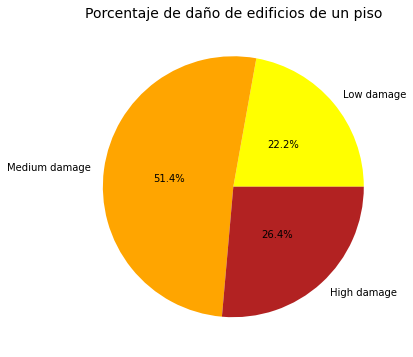

In [658]:
pie, ax = plt.subplots(figsize=[10,6])

plt.pie(x=plot['total_un_piso'], autopct="%.1f%%",\
        labels=['Low damage', 'Medium damage', 'High damage'], colors=["yellow", "orange", "firebrick"], pctdistance=0.5)
plt.title("Porcentaje de daño de edificios de un piso", fontsize=14);

#### Analisis de edad para edificios de un piso

Text(0, 0.5, 'Año')

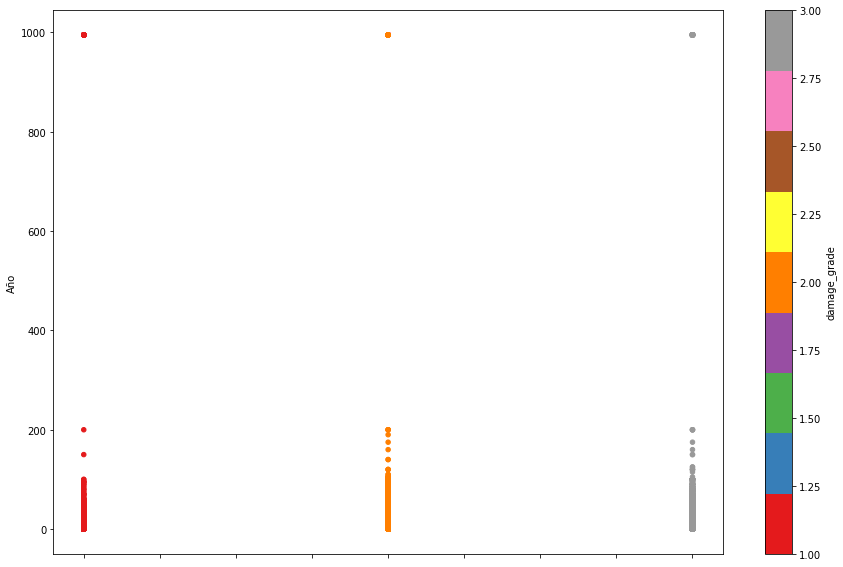

In [659]:
un_pisoDF.plot.scatter(x='damage_grade', y='age', c='damage_grade', colormap='Set1', figsize= (15, 10))
plt.xlabel('Daño')
plt.ylabel('Año')

Se observa que para los edificios de un piso las edades de estos no tienen relacion directa con el grado de daño, ya que se cuenta con datos de edificios de mismas edades con distintos tipos de daños.

###Edificios de 2 pisos

In [660]:
dos_pisosDF = pisosDF.groupby('count_floors_pre_eq').get_group(2)
plot = dos_pisosDF.copy()
del plot['count_floors_pre_eq']
del plot['age']
plot['total_dos_pisos'] = plot.groupby('damage_grade')['damage_grade'].transform('count')
plot = plot.set_index('damage_grade').drop_duplicates()

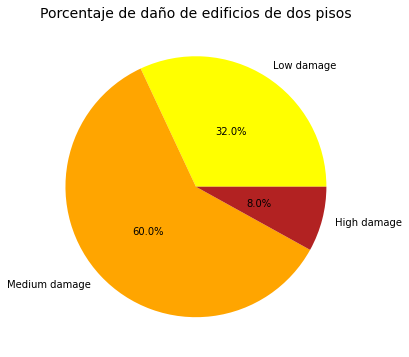

In [661]:
pie, ax = plt.subplots(figsize=[10,6])

plt.pie(x=plot['total_dos_pisos'], autopct="%.1f%%",\
        labels=['Low damage', 'Medium damage', 'High damage'], colors=["yellow", "orange", "firebrick"], pctdistance=0.5)
plt.title("Porcentaje de daño de edificios de dos pisos", fontsize=14);

#### Analisis de edad para edificios de dos pisos

Text(0, 0.5, 'Año')

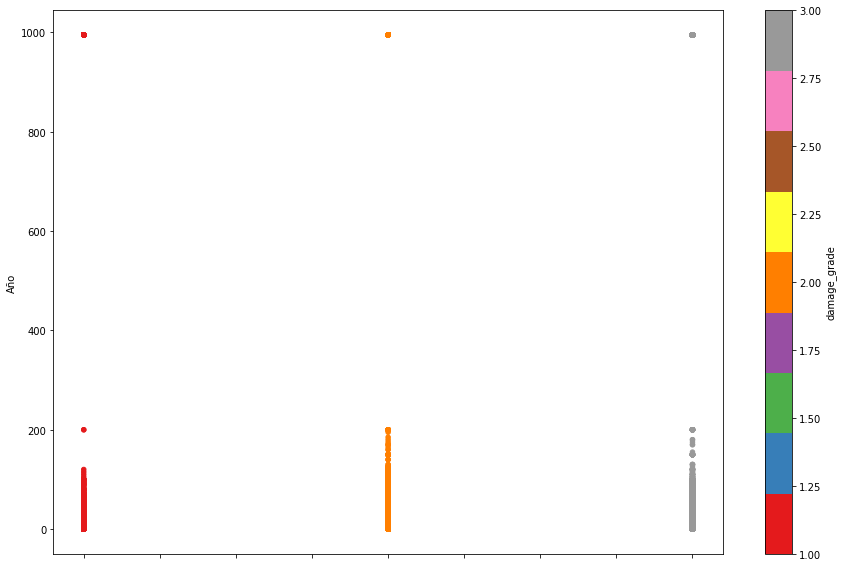

In [662]:
dos_pisosDF.plot.scatter(x='damage_grade', y='age', c='damage_grade', colormap='Set1', figsize= (15, 10))
plt.xlabel('Daño')
plt.ylabel('Año')

Al igual que para el caso anterior se observa que para los edificios de dos pisos las edades de estos no tienen relacion directa con el grado de daño, ya que se cuenta con datos de edificios de mismas edades con distintos tipos de daños.

###Edificios de 3 pisos

In [663]:
tres_pisosDF = pisosDF.groupby('count_floors_pre_eq').get_group(3)
plot = tres_pisosDF.copy()
del plot['count_floors_pre_eq']
del plot['age']
plot['total_tres_pisos'] = plot.groupby('damage_grade')['damage_grade'].transform('count')
plot = plot.set_index('damage_grade').drop_duplicates()

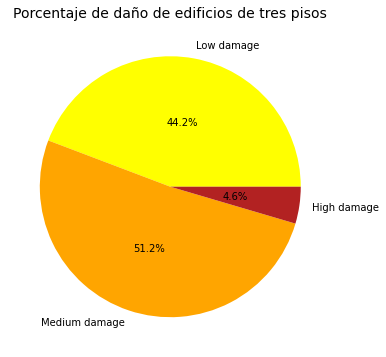

In [664]:
pie, ax = plt.subplots(figsize=[10,6])

plt.pie(x=plot['total_tres_pisos'], autopct="%.1f%%",\
        labels=['Low damage', 'Medium damage', 'High damage'], colors=["yellow", "orange", "firebrick"], pctdistance=0.5)
plt.title("Porcentaje de daño de edificios de tres pisos", fontsize=14);

#### Analisis de edad para edificios de tres pisos

Text(0, 0.5, 'Año')

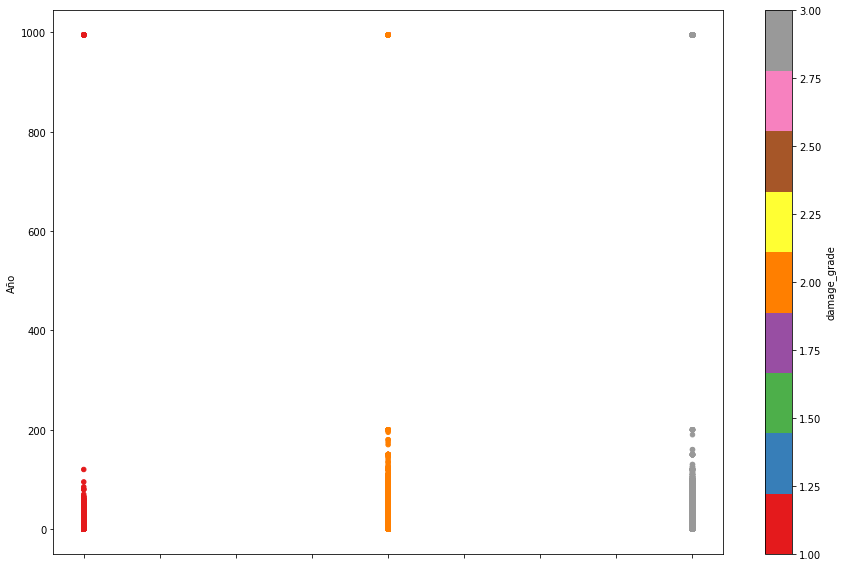

In [665]:
tres_pisosDF.plot.scatter(x='damage_grade', y='age', c='damage_grade', colormap='Set1', figsize= (15, 10))
plt.xlabel('Daño')
plt.ylabel('Año')

De igual manera que los anteriores, se observa que para los edificios de tres pisos las edades de estos tienen no relacion directa con el grado de daño, ya que se cuenta con datos de edificios de mismas edades con distintos tipos de daños.

###Edificios de 4 pisos o más

In [666]:
cuatro_mas_pisosDF = pisosDF.groupby('count_floors_pre_eq').get_group(4)
plot = cuatro_mas_pisosDF.copy()
del plot['count_floors_pre_eq']
del plot['age']
plot['total_cuatro_mas_pisos'] = plot.groupby('damage_grade')['damage_grade'].transform('count')
plot = plot.set_index('damage_grade').drop_duplicates()

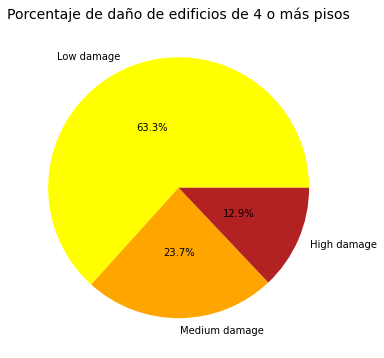

In [667]:
pie, ax = plt.subplots(figsize=[10,6])

plt.pie(x=plot['total_cuatro_mas_pisos'], autopct="%.1f%%",\
        labels=['Low damage', 'Medium damage', 'High damage'], colors=["yellow", "orange", "firebrick"], pctdistance=0.5)
plt.title("Porcentaje de daño de edificios de 4 o más pisos", fontsize=14);

#### Analisis de edad para edificios de cuatro pisos o más

Text(0, 0.5, 'Año')

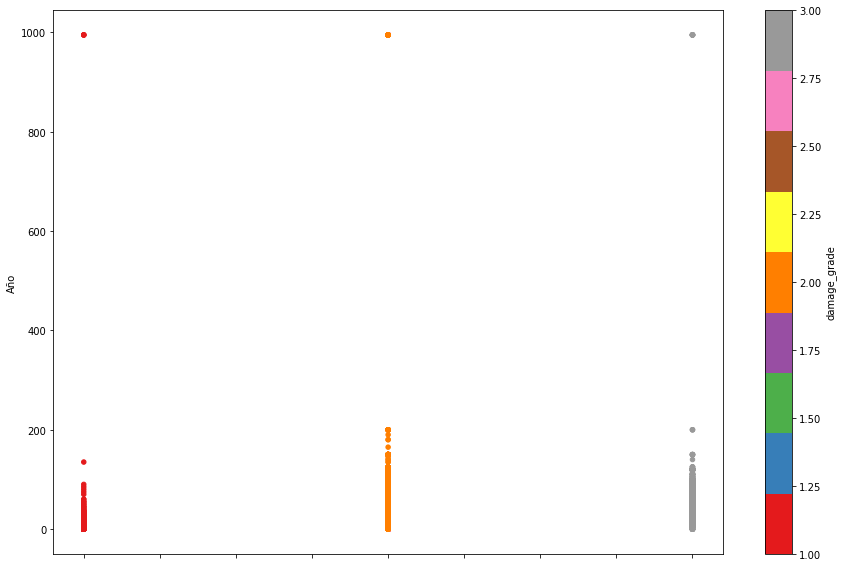

In [668]:
cuatro_mas_pisosDF.plot.scatter(x='damage_grade', y='age', c='damage_grade', colormap='Set1', figsize= (15, 10))
plt.xlabel('Daño')
plt.ylabel('Año')

De igual manera que los anteriores, se observa que para los edificios de tres pisos las edades de estos tienen no relacion directa con el grado de daño, ya que se cuenta con datos de edificios de mismas edades con distintos tipos de daños.

###Analisis de promedio

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f07bcdf17d0>],
      dtype=object)

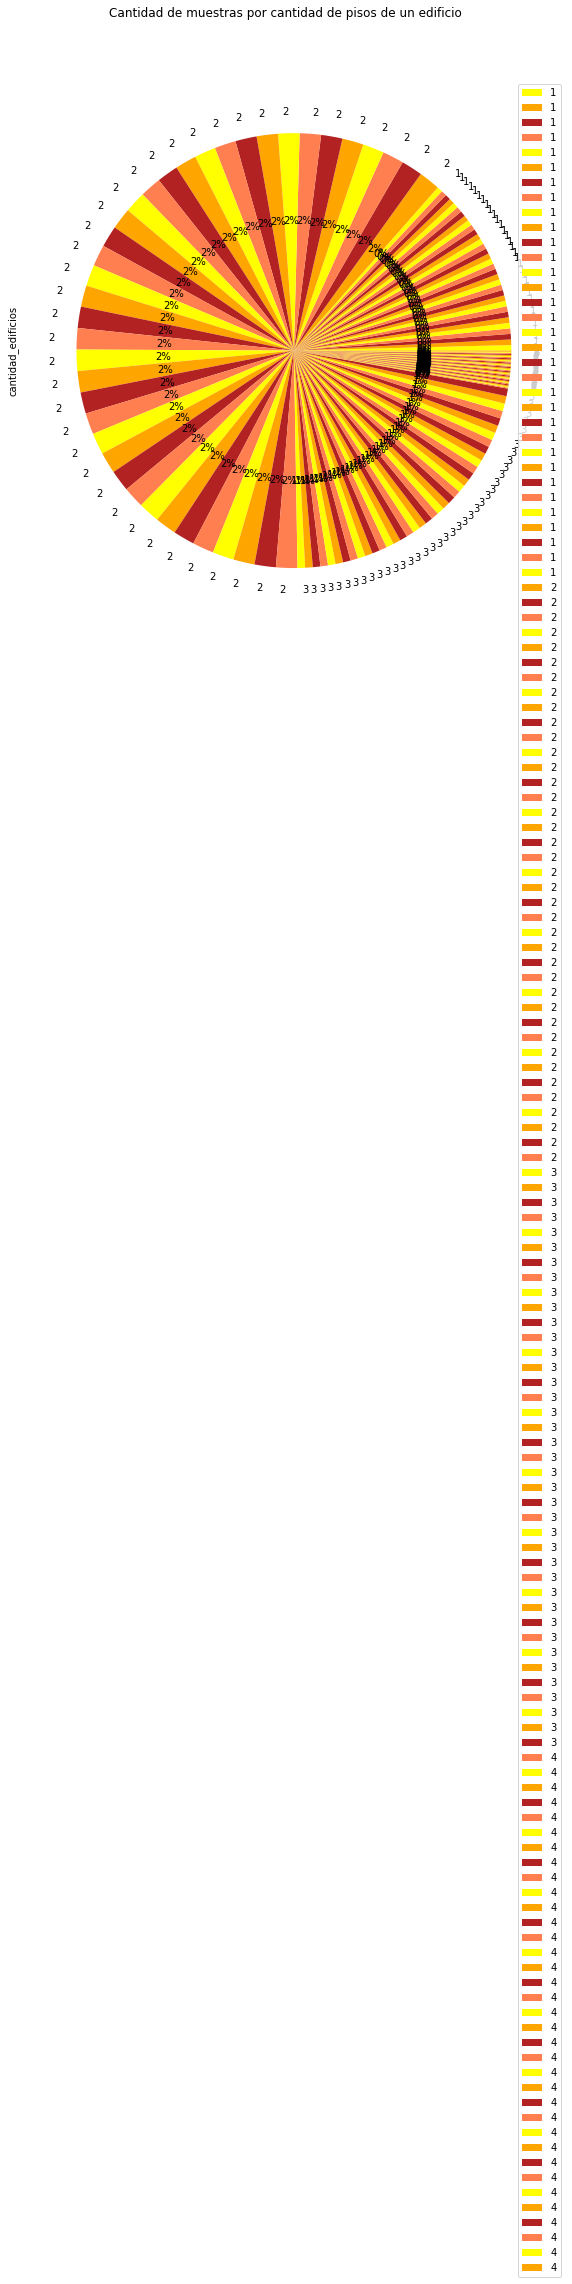

In [669]:
pisosDF['promedio_danio'] = pisosDF.groupby('count_floors_pre_eq')['damage_grade'].transform('mean')
pisosDF['cantidad_edificios'] = pisosDF.groupby('count_floors_pre_eq')['damage_grade'].transform('count')
del pisosDF['damage_grade']
pisosDF = pisosDF.sort_values(('count_floors_pre_eq'), ascending = True).set_index('count_floors_pre_eq').drop_duplicates()

pisosDF.loc[:,['cantidad_edificios']].plot.pie(x='count_floors_pre_eq', figsize=(10, 10), subplots=True, autopct="%.0f%%", title= "Cantidad de muestras por cantidad de pisos de un edificio", colors = ['yellow', 'orange', 'firebrick', 'coral'] )

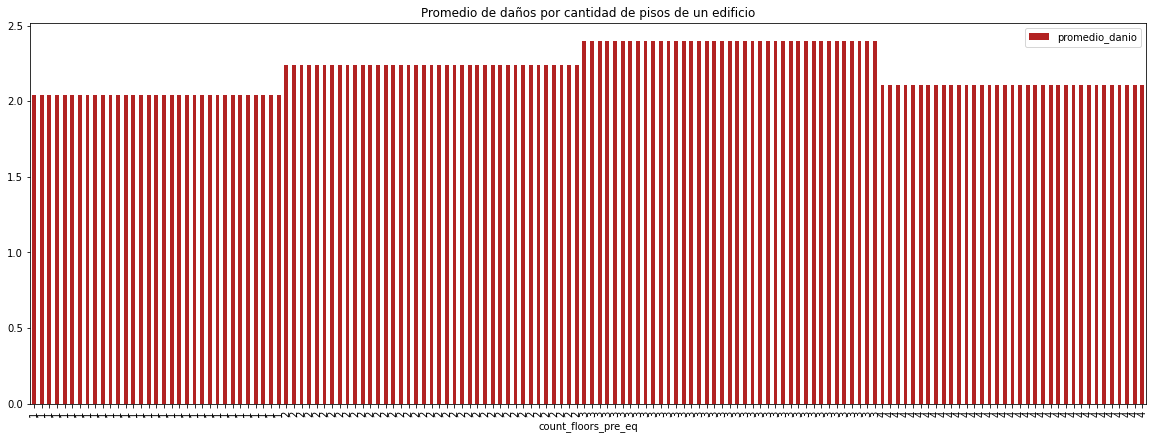

In [670]:
pisosDF.loc[:,['promedio_danio']].plot(kind= 'bar', figsize= (20, 7), title= "Promedio de daños por cantidad de pisos de un edificio", color= 'firebrick')

Analizando los edificios por cantidad de pisos por separado, se observo que los edificios de un sólo piso son los más afectador a un daño mayor en porcentage seguido de los de 4 pisos o más.
Luego del análisis por promedio, del segundo grafico se observa que el daño promedio por cantidad de pisos es casi independiente de la cantidad de pisos, ya que presentan valores ligeramente diferentes. Se llega a la conclusion que los edificios con sólo un piso fueron los mas dañados pero no en gran diferencia del resto.

##Analisis por superficie normalizada ocupada por el edificio

In [671]:
estructuraDimensiones['area_percentage'].value_counts()

6      42013
7      36752
5      32724
8      28445
9      22199
       ...  
82         1
80         1
78         1
75         1
100        1
Name: area_percentage, Length: 84, dtype: int64

In [672]:
areasDF = estructuraDimensiones.loc[:,['area_percentage', 'damage_grade']]
areasDF['promedio_danio'] = areasDF.groupby('area_percentage')['damage_grade'].transform('mean')
areasDF['cantidad_edificios'] = areasDF.groupby('area_percentage')['damage_grade'].transform('count')
del areasDF['damage_grade']
areasDF = areasDF.drop_duplicates()
areasDF = areasDF.sort_values(('area_percentage'), ascending = True).set_index('area_percentage')

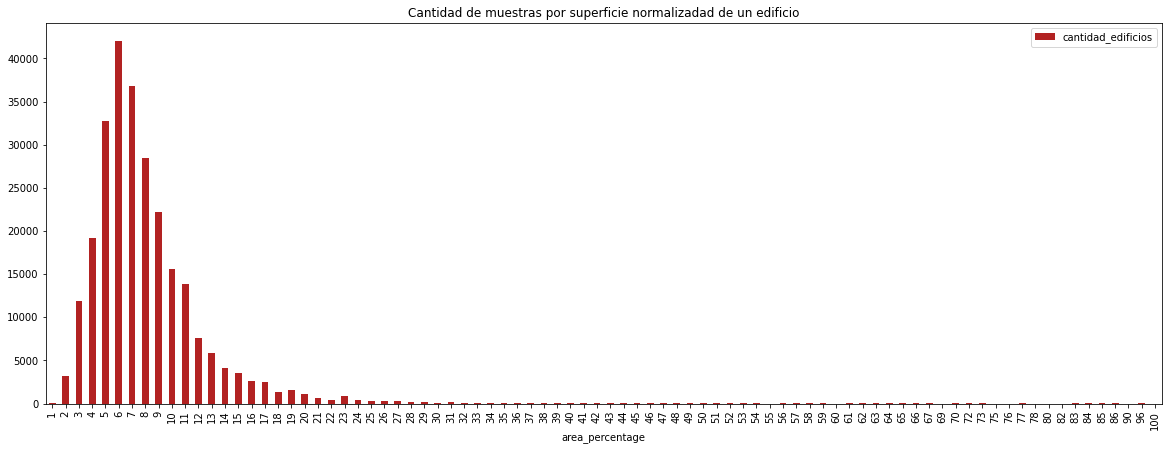

In [673]:
areasDF.loc[:,['cantidad_edificios']].plot(kind= 'bar', figsize= (20, 7), title= "Cantidad de muestras por superficie normalizadad de un edificio", color= 'firebrick')

Observamos que se tiene escaza muestra para edificios con superficie normalizada mayor a 20, por lo cual descartaremos a estos para el analisis

In [674]:
areasDF = areasDF.loc[areasDF.index < 21]

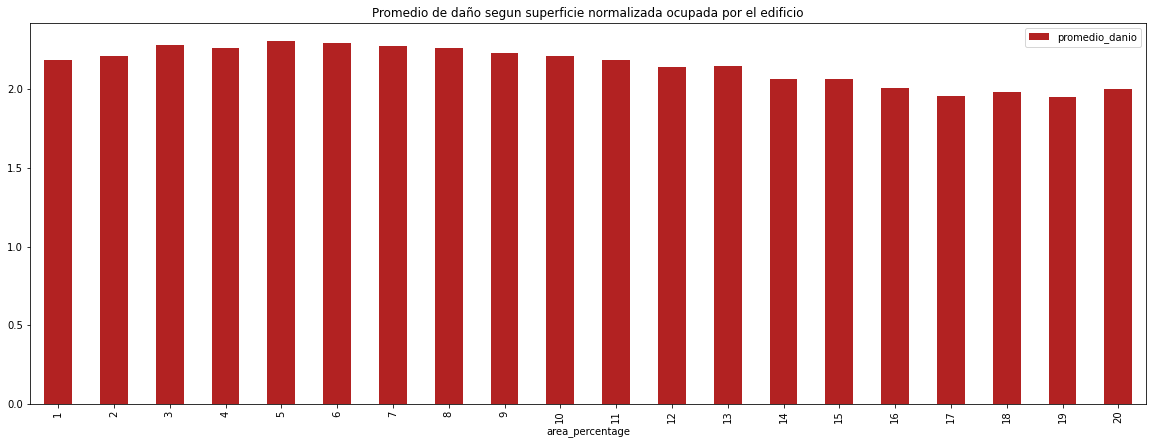

In [675]:
areasDF.loc[:, ['promedio_danio']].plot(kind= 'bar', figsize= (20, 7), title= "Promedio de daño segun superficie normalizada ocupada por el edificio", color= 'firebrick')

Se observa que la superficie normalizada de un edificio no afecta a el daño promedio directamente. Los edificios con una superficie normalizada menor a 10 presenta un daño levemente mayor al resto.

##Analisis por altura normalizada ocupada por el edificio

In [676]:
estructuraDimensiones['height_percentage'].value_counts()

5     78513
6     46477
4     37763
7     35465
3     25957
8     13902
2      9305
9      5376
10     4492
11      917
12      907
13      759
15      292
16      179
32       75
18       71
14       66
20       33
21       13
23       11
17        9
19        7
24        4
25        3
26        2
28        2
31        1
Name: height_percentage, dtype: int64

In [677]:
alturasDF = estructuraDimensiones.loc[:,['height_percentage', 'damage_grade']]
alturasDF['promedio_danio'] = alturasDF.groupby('height_percentage')['damage_grade'].transform('mean')
alturasDF['cantidad_edificios'] = alturasDF.groupby('height_percentage')['damage_grade'].transform('count')
del alturasDF['damage_grade']
alturasDF = alturasDF.drop_duplicates()
alturasDF = alturasDF.sort_values(('height_percentage'), ascending = True).set_index('height_percentage')

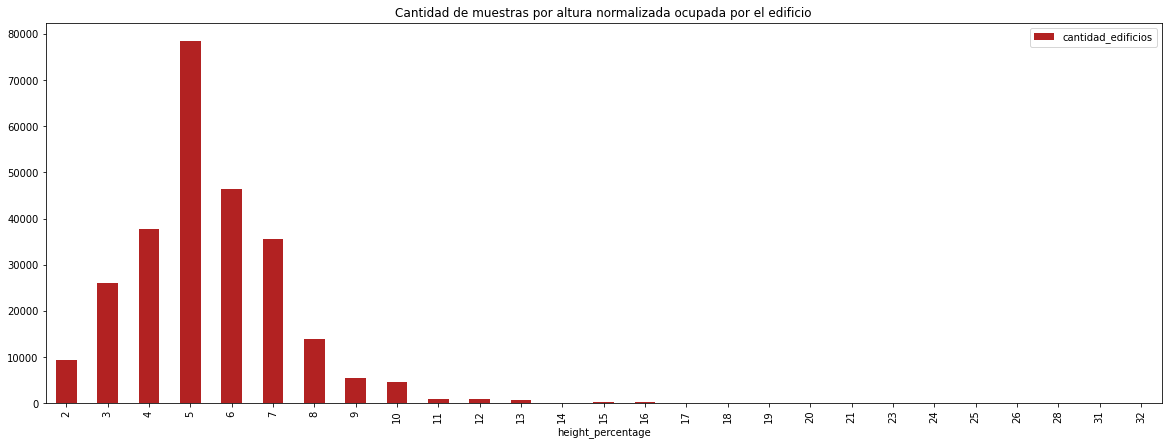

In [678]:
alturasDF.loc[:,['cantidad_edificios']].plot(kind= 'bar', figsize= (20, 7), title= "Cantidad de muestras por altura normalizada ocupada por el edificio", color= 'firebrick')

La cantidad de muestra de edificios con altura normalizada mayor a 10 es escaza por lo que se decide descartar esos datos para el analisis.

In [679]:
alturasDF = alturasDF.loc[alturasDF.index < 11]

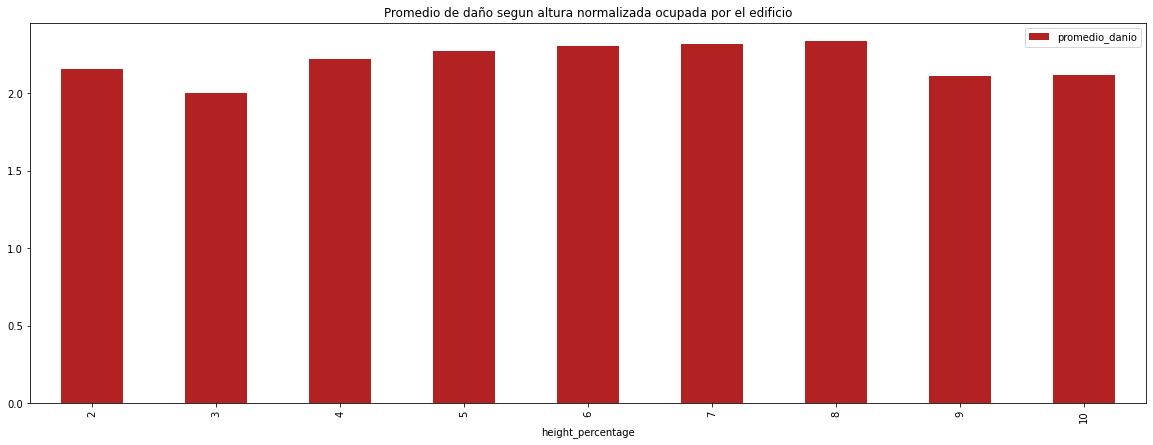

In [680]:
alturasDF.loc[:, ['promedio_danio']].plot(kind= 'bar', figsize= (20, 7), title= "Promedio de daño segun altura normalizada ocupada por el edificio", color= 'firebrick')

El gráfico anterior demuestra que la altura normalizada ocupada no tiene realicion directa con el daño promedio ocasionado a la edifiacion.

A continuacion analizaremos la desviacion entre alturas normalizadas y cantidad de pisos.

In [681]:
alturas_pisosDF = estructuraDimensiones.loc[:,['count_floors_pre_eq','height_percentage', 'damage_grade']]
alturas_pisosDF.loc[alturas_pisosDF['count_floors_pre_eq'] > 4, 'count_floors_pre_eq'] = 4

Text(0, 0.5, 'Altura')

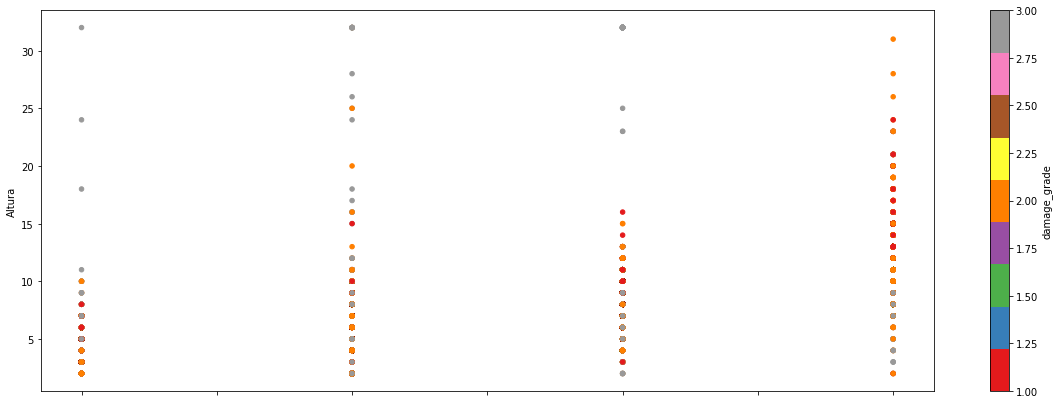

In [682]:
alturas_pisosDF.plot.scatter(x='count_floors_pre_eq', y='height_percentage', c='damage_grade', colormap='Set1', figsize= (20, 7))
plt.xlabel('Cantidad de pisos')
plt.ylabel('Altura')

En este ultimo graficos se puede observar la relacion entre la cantidad de pisos, las variantes de alturas y el daño ocacionado por el fenomeno. Del mismo no obtenemos nada nuevo, solamente reafirmamos que la dispersion de daños no tiene una relacion directa significante con estas caracteristicas de los edificios.

##Analisis por condicion de la superficie terrestre del edificio

In [683]:
estructuraDimensiones['land_surface_condition'].value_counts()

t    216757
n     35528
o      8316
Name: land_surface_condition, dtype: int64

In [684]:
cond_sueloDF = estructuraDimensiones.loc[:,['land_surface_condition', 'damage_grade', 'age']]

### Analisis de daño para la condicion de superficie n

In [685]:
cond_n = cond_sueloDF.groupby('land_surface_condition').get_group('n')
plot = cond_n.copy()
plot['total_edif_danio'] = plot.groupby('damage_grade')['damage_grade'].transform('count')
del plot['land_surface_condition']
del plot['age']
plot = plot.set_index('damage_grade').drop_duplicates()

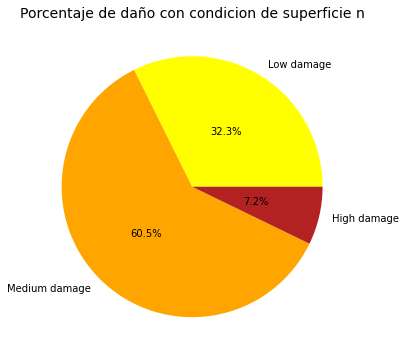

In [686]:
pie, ax = plt.subplots(figsize=[10,6])

plt.pie(x=plot['total_edif_danio'], autopct="%.1f%%",\
        labels=['Low damage', 'Medium damage', 'High damage'], colors=["yellow", "orange", "firebrick"], pctdistance=0.5)
plt.title("Porcentaje de daño con condicion de superficie n", fontsize=14);

#### Analisis de edad para edificios construidos sobre superficies de condicion n

Text(0, 0.5, 'Año')

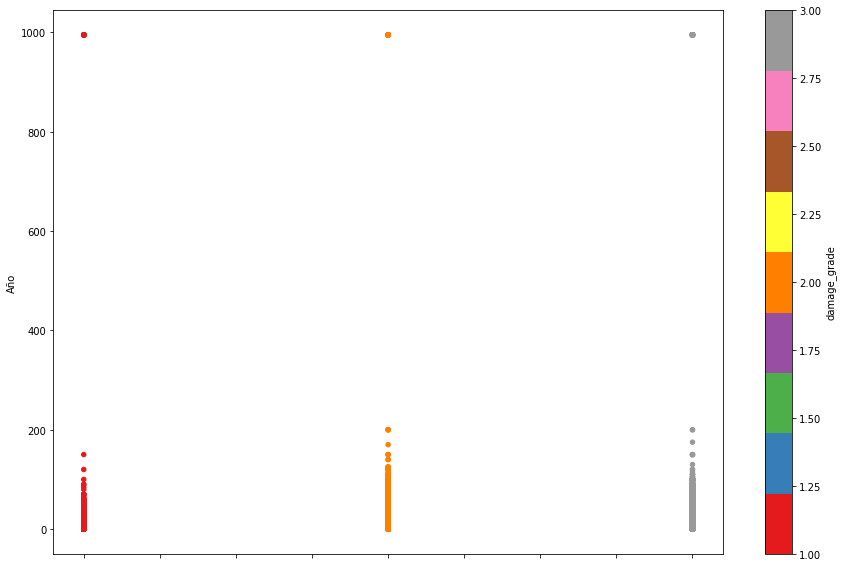

In [687]:
cond_n.plot.scatter(x='damage_grade', y='age', c='damage_grade', colormap='Set1', figsize= (15, 10))
plt.xlabel('Daño')
plt.ylabel('Año')

Se observa que para los edificios construidos sobre una superficie de condicion n las edades de estos no tienen relacion directa con el grado de daño, ya que se cuenta con datos de edificios de mismas edades con distintos tipos de daños.

### Analisis de daño para la condicion de superficie o

In [688]:
cond_o = cond_sueloDF.groupby('land_surface_condition').get_group('o')
plot = cond_o.copy()
plot['total_edif_danio'] = plot.groupby('damage_grade')['damage_grade'].transform('count')
del plot['land_surface_condition']
del plot['age']
plot = plot.set_index('damage_grade').drop_duplicates()

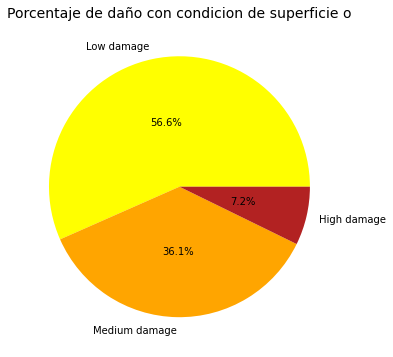

In [689]:
pie, ax = plt.subplots(figsize=[10,6])

plt.pie(x=plot['total_edif_danio'], autopct="%.1f%%",\
        labels=['Low damage', 'Medium damage', 'High damage'], colors=["yellow", "orange", "firebrick"], pctdistance=0.5)
plt.title("Porcentaje de daño con condicion de superficie o", fontsize=14);

#### Analisis de edad para edificios construidos sobre superficies de condicion o

Text(0, 0.5, 'Año')

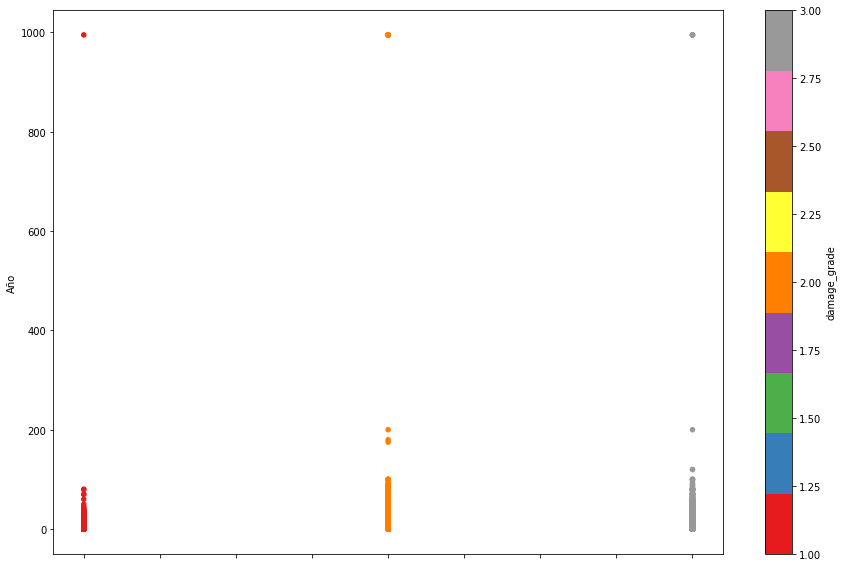

In [690]:
cond_o.plot.scatter(x='damage_grade', y='age', c='damage_grade', colormap='Set1', figsize= (15, 10))
plt.xlabel('Daño')
plt.ylabel('Año')

Se observa que para los edificios construidos sobre una superficie de condicion o las edades de estos no tienen relacion directa con el grado de daño, ya que se cuenta con datos de edificios de mismas edades con distintos tipos de daños.

### Analisis de daño para la condicion de superficie t

In [691]:
cond_t = cond_sueloDF.groupby('land_surface_condition').get_group('t')
plot = cond_t.copy()
plot['total_edif_danio'] = plot.groupby('damage_grade')['damage_grade'].transform('count')
del plot['land_surface_condition']
del plot['age']
plot = plot.set_index('damage_grade').drop_duplicates()

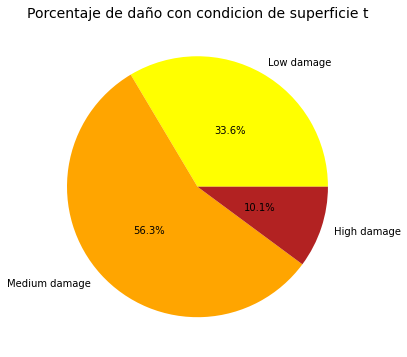

In [692]:
pie, ax = plt.subplots(figsize=[10,6])

plt.pie(x=plot['total_edif_danio'], autopct="%.1f%%",\
        labels=['Low damage', 'Medium damage', 'High damage'], colors=["yellow", "orange", "firebrick"], pctdistance=0.5)
plt.title("Porcentaje de daño con condicion de superficie t", fontsize=14);

#### Analisis de edad para edificios construidos sobre superficies de condicion t

Text(0, 0.5, 'Año')

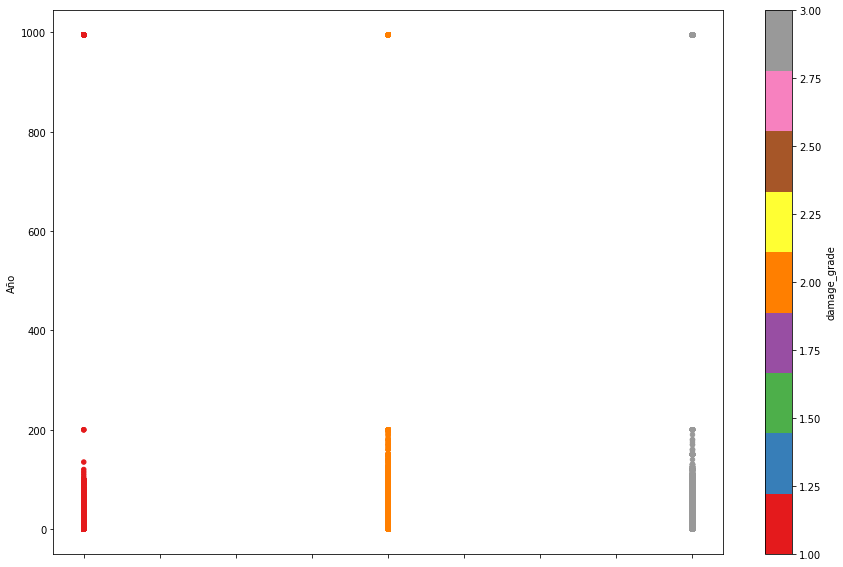

In [693]:
cond_t.plot.scatter(x='damage_grade', y='age', c='damage_grade', colormap='Set1', figsize= (15, 10))
plt.xlabel('Daño')
plt.ylabel('Año')

Se observa que para los edificios construidos sobre una superficie de condicion t las edades de estos no tienen relacion directa con el grado de daño, ya que se cuenta con datos de edificios de mismas edades con distintos tipos de daños.

### Análisis por promedio

In [694]:
cond_sueloDF['promedio_danio'] = cond_sueloDF.groupby('land_surface_condition')['damage_grade'].transform('mean')
cond_sueloDF['cantidad_edificios'] = cond_sueloDF.groupby('land_surface_condition')['damage_grade'].transform('count')
del cond_sueloDF['damage_grade']
cond_sueloDF = cond_sueloDF.drop_duplicates()
cond_sueloDF = cond_sueloDF.sort_values(('land_surface_condition'), ascending = True).set_index('land_surface_condition')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f07be34a390>],
      dtype=object)

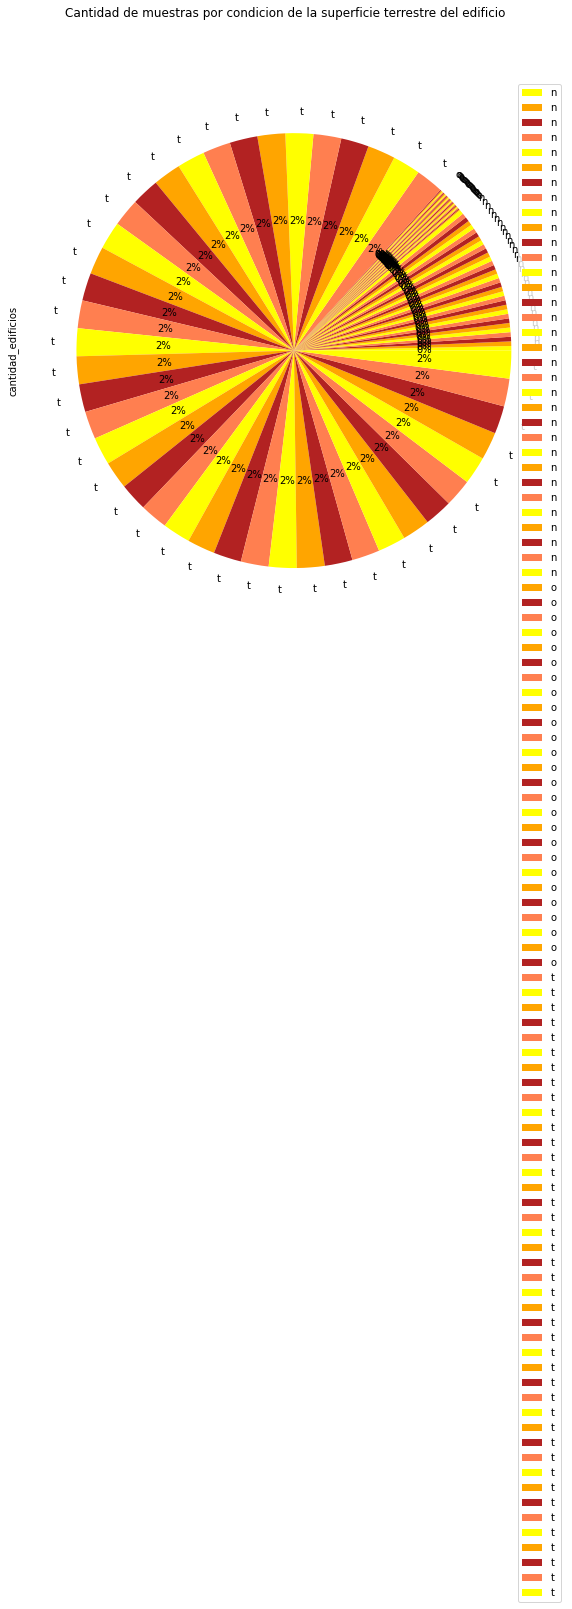

In [695]:
cond_sueloDF.loc[:,['cantidad_edificios']].plot.pie(x='land_surface_condition', figsize=(10, 10), subplots=True, autopct="%.0f%%", title= "Cantidad de muestras por condicion de la superficie terrestre del edificio", colors = ['yellow', 'orange', 'firebrick', 'coral'])

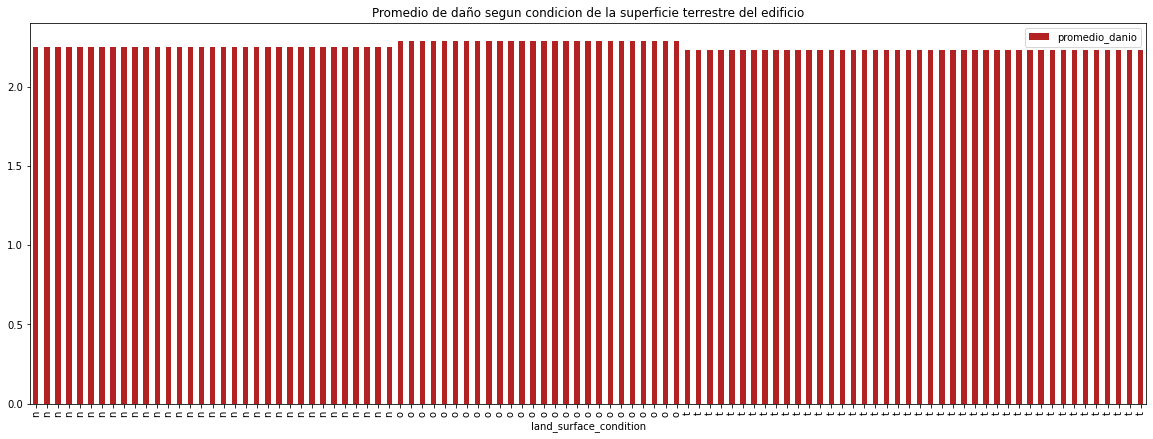

In [696]:
cond_sueloDF.loc[:, ['promedio_danio']].plot(kind= 'bar', figsize= (20, 7), title= "Promedio de daño segun condicion de la superficie terrestre del edificio", color= 'firebrick')

Respecto al análisis de superficie, la condición de superficie de tipo "t" presenta mayor promedio de mayor daño en comparación de los otros tipos de condiciones. Por otro lado en el analisis por promedio, si bien no se cuenta con cantidad de muestras equivalentes para cada tipo de condición de superficie, las otorgadas son suficientes para visualizar que en promedio, la condicion de la superficie de la construccion no es un factor que afecta al daño del fenómeno.

##Analisis por orientación del edificio

In [697]:
estructuraDimensiones['position'].value_counts()

s    202090
t     42896
j     13282
o      2333
Name: position, dtype: int64

In [698]:
posicionesDF = estructuraDimensiones.loc[:,['position', 'damage_grade']]

### Analisis de orientacion s

In [699]:
orientacion_s = posicionesDF.groupby('position').get_group('s')
orientacion_s['total_edif_danio'] = orientacion_s.groupby('damage_grade')['damage_grade'].transform('count')
del orientacion_s['position']
orientacion_s = orientacion_s.set_index('damage_grade').drop_duplicates()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


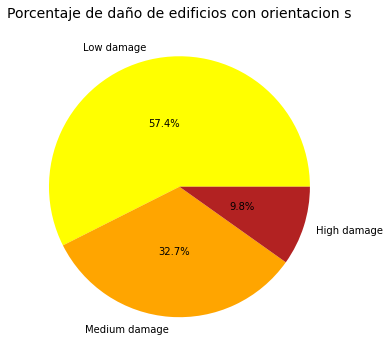

In [700]:
pie, ax = plt.subplots(figsize=[10,6])

plt.pie(x=orientacion_s['total_edif_danio'], autopct="%.1f%%",\
        labels=['Low damage', 'Medium damage', 'High damage'], colors=["yellow", "orange", "firebrick"], pctdistance=0.5)
plt.title("Porcentaje de daño de edificios con orientacion s", fontsize=14);

### Analisis de orientacion t

In [701]:
orientacion_t = posicionesDF.groupby('position').get_group('t')
orientacion_t['total_edif_danio'] = orientacion_t.groupby('damage_grade')['damage_grade'].transform('count')
del orientacion_t['position']
orientacion_t = orientacion_t.set_index('damage_grade').drop_duplicates()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


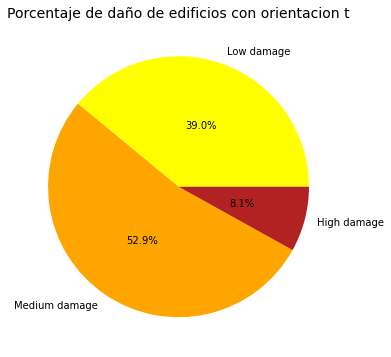

In [702]:
pie, ax = plt.subplots(figsize=[10,6])

plt.pie(x=orientacion_t['total_edif_danio'], autopct="%.1f%%",\
        labels=['Low damage', 'Medium damage', 'High damage'], colors=["yellow", "orange", "firebrick"], pctdistance=0.5)
plt.title("Porcentaje de daño de edificios con orientacion t", fontsize=14);

### Analisis de orientacion j

In [703]:
orientacion_j = posicionesDF.groupby('position').get_group('j')
orientacion_j['total_edif_danio'] = orientacion_j.groupby('damage_grade')['damage_grade'].transform('count')
del orientacion_j['position']
orientacion_j = orientacion_j.set_index('damage_grade').drop_duplicates()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


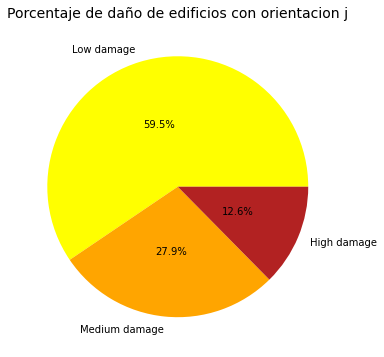

In [704]:
pie, ax = plt.subplots(figsize=[10,6])

plt.pie(x=orientacion_j['total_edif_danio'], autopct="%.1f%%",\
        labels=['Low damage', 'Medium damage', 'High damage'], colors=["yellow", "orange", "firebrick"], pctdistance=0.5)
plt.title("Porcentaje de daño de edificios con orientacion j", fontsize=14);

### Analisis de orientacion o

In [705]:
orientacion_o = posicionesDF.groupby('position').get_group('o')
orientacion_o['total_edif_danio'] = orientacion_o.groupby('damage_grade')['damage_grade'].transform('count')
del orientacion_o['position']
orientacion_o = orientacion_o.set_index('damage_grade').drop_duplicates()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


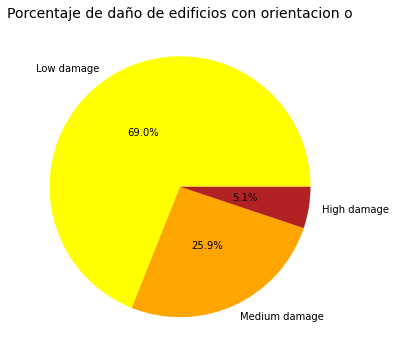

In [706]:
pie, ax = plt.subplots(figsize=[10,6])

plt.pie(x=orientacion_o['total_edif_danio'], autopct="%.1f%%",\
        labels=['Low damage', 'Medium damage', 'High damage'], colors=["yellow", "orange", "firebrick"], pctdistance=0.5)
plt.title("Porcentaje de daño de edificios con orientacion o", fontsize=14);

### Análisis por promedio

In [707]:
posicionesDF['promedio_danio'] = posicionesDF.groupby('position')['damage_grade'].transform('mean')
posicionesDF['cantidad_edificios'] = posicionesDF.groupby('position')['damage_grade'].transform('count')
del posicionesDF['damage_grade']
posicionesDF = posicionesDF.drop_duplicates()
posicionesDF = posicionesDF.sort_values(('position'), ascending = True).set_index('position')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f07bab74690>],
      dtype=object)

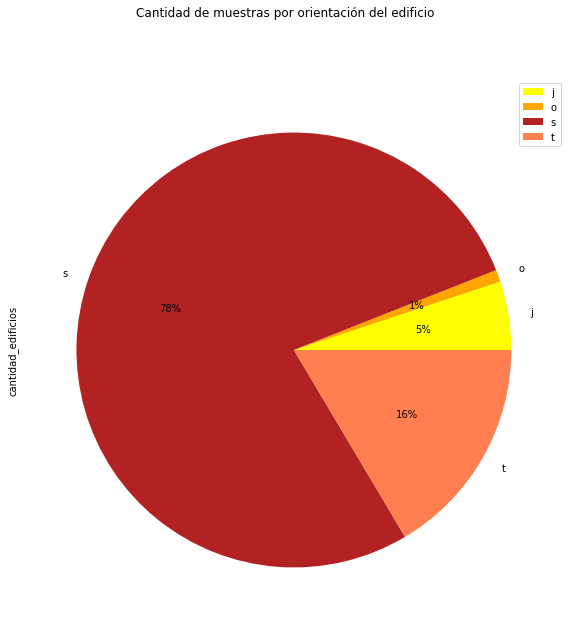

In [708]:
posicionesDF.loc[:,['cantidad_edificios']].plot.pie(x='position', figsize=(10, 10), subplots=True, autopct="%.0f%%", title= "Cantidad de muestras por orientación del edificio", colors = ['yellow', 'orange', 'firebrick', 'coral'])

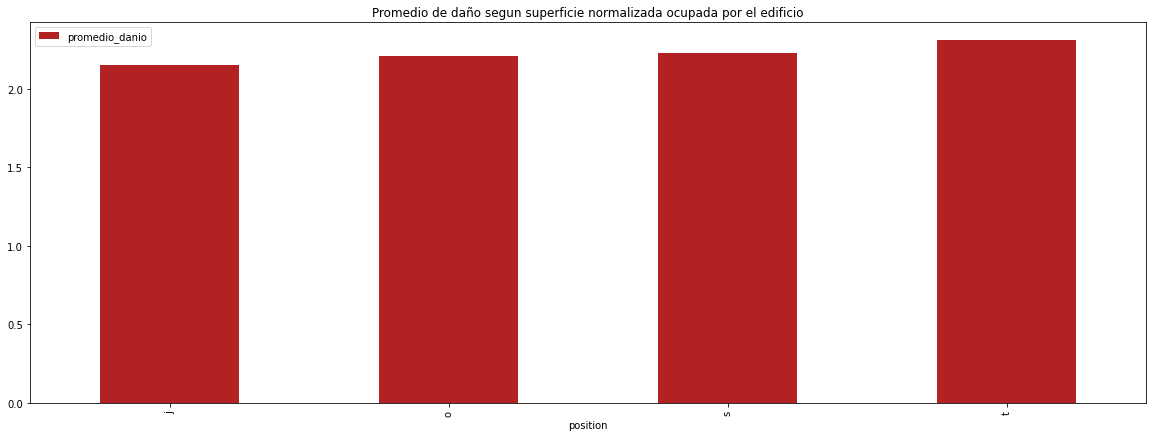

In [709]:
posicionesDF.loc[:, ['promedio_danio']].plot(kind= 'bar', figsize= (20, 7), title= "Promedio de daño segun superficie normalizada ocupada por el edificio", color= 'firebrick')

Respecto al analisis por porcentaje de daños para las diferentes orientaciones de los edificios, la orientación de tipo "j" presenta mayor porcentage de daño mayor en sus edificios. Por otro lado para el analisis pro promedio, al igual que el caso de la condición de superficie, se visualiza que la orientación de la construccion no es un factor que afecta significativa al daño del fenómeno.

##Analisis por formato de construccion de la edificación (diseño sismico)

In [710]:
estructuraDimensiones['plan_configuration'].value_counts()

d    250072
q      5692
u      3649
s       346
c       325
a       252
o       159
m        46
n        38
f        22
Name: plan_configuration, dtype: int64

In [711]:
formatosDF = estructuraDimensiones.loc[:,['plan_configuration', 'damage_grade']]

### Analisis de diseño d

In [712]:
diseño_d = formatosDF.groupby('plan_configuration').get_group('d')
diseño_d['total_edif_danio'] = diseño_d.groupby('damage_grade')['damage_grade'].transform('count')
del diseño_d['plan_configuration']
diseño_d = diseño_d.set_index('damage_grade').drop_duplicates()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


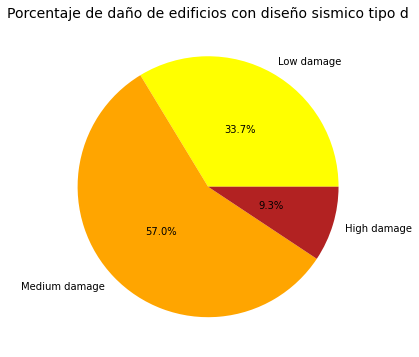

In [713]:
pie, ax = plt.subplots(figsize=[10,6])

plt.pie(x=diseño_d['total_edif_danio'], autopct="%.1f%%",\
        labels=['Low damage', 'Medium damage', 'High damage'], colors=["yellow", "orange", "firebrick"], pctdistance=0.5)
plt.title("Porcentaje de daño de edificios con diseño sismico tipo d", fontsize=14);

### Analisis de diseño q

In [714]:
diseño_q = formatosDF.groupby('plan_configuration').get_group('q')
diseño_q['total_edif_danio'] = diseño_q.groupby('damage_grade')['damage_grade'].transform('count')
del diseño_q['plan_configuration']
diseño_q = diseño_q.set_index('damage_grade').drop_duplicates()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


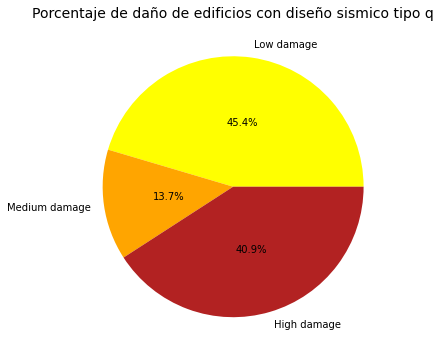

In [715]:
pie, ax = plt.subplots(figsize=[10,6])

plt.pie(x=diseño_q['total_edif_danio'], autopct="%.1f%%",\
        labels=['Low damage', 'Medium damage', 'High damage'], colors=["yellow", "orange", "firebrick"], pctdistance=0.5)
plt.title("Porcentaje de daño de edificios con diseño sismico tipo q", fontsize=14);

### Analisis de diseño u

In [716]:
diseño_u = formatosDF.groupby('plan_configuration').get_group('u')
diseño_u['total_edif_danio'] = diseño_u.groupby('damage_grade')['damage_grade'].transform('count')
del diseño_u['plan_configuration']
diseño_u = diseño_u.set_index('damage_grade').drop_duplicates()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


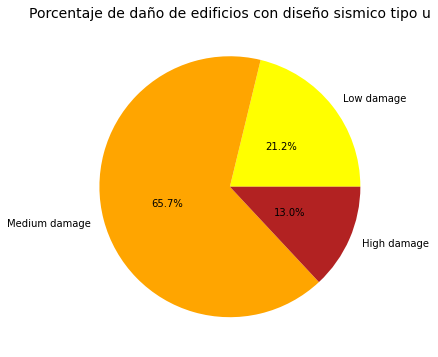

In [717]:
pie, ax = plt.subplots(figsize=[10,6])

plt.pie(x=diseño_u['total_edif_danio'], autopct="%.1f%%",\
        labels=['Low damage', 'Medium damage', 'High damage'], colors=["yellow", "orange", "firebrick"], pctdistance=0.5)
plt.title("Porcentaje de daño de edificios con diseño sismico tipo u", fontsize=14);

### Analisis de diseño s

In [718]:
diseño_s = formatosDF.groupby('plan_configuration').get_group('s')
diseño_s['total_edif_danio'] = diseño_s.groupby('damage_grade')['damage_grade'].transform('count')
del diseño_s['plan_configuration']
diseño_s = diseño_s.set_index('damage_grade').drop_duplicates()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


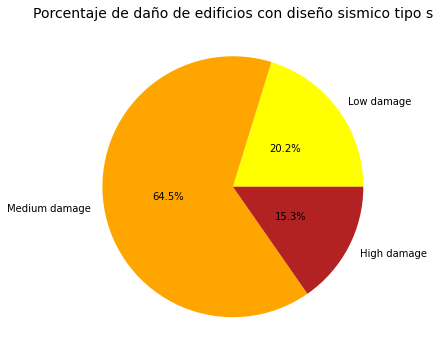

In [719]:
pie, ax = plt.subplots(figsize=[10,6])

plt.pie(x=diseño_s['total_edif_danio'], autopct="%.1f%%",\
        labels=['Low damage', 'Medium damage', 'High damage'], colors=["yellow", "orange", "firebrick"], pctdistance=0.5)
plt.title("Porcentaje de daño de edificios con diseño sismico tipo s", fontsize=14);

### Analisis de diseño c

In [720]:
diseño_c = formatosDF.groupby('plan_configuration').get_group('c')
diseño_c['total_edif_danio'] = diseño_c.groupby('damage_grade')['damage_grade'].transform('count')
del diseño_c['plan_configuration']
diseño_c = diseño_c.set_index('damage_grade').drop_duplicates()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


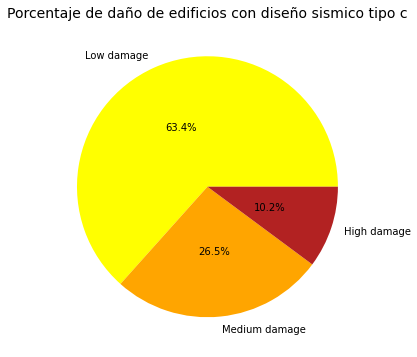

In [721]:
pie, ax = plt.subplots(figsize=[10,6])

plt.pie(x=diseño_c['total_edif_danio'], autopct="%.1f%%",\
        labels=['Low damage', 'Medium damage', 'High damage'], colors=["yellow", "orange", "firebrick"], pctdistance=0.5)
plt.title("Porcentaje de daño de edificios con diseño sismico tipo c", fontsize=14);

### Analisis de diseño a

In [722]:
diseño_a = formatosDF.groupby('plan_configuration').get_group('a')
diseño_a['total_edif_danio'] = diseño_a.groupby('damage_grade')['damage_grade'].transform('count')
del diseño_a['plan_configuration']
diseño_a = diseño_a.set_index('damage_grade').drop_duplicates()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


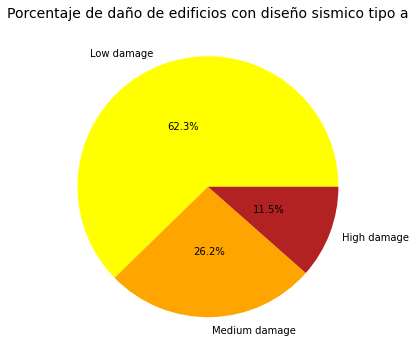

In [723]:
pie, ax = plt.subplots(figsize=[10,6])

plt.pie(x=diseño_a['total_edif_danio'], autopct="%.1f%%",\
        labels=['Low damage', 'Medium damage', 'High damage'], colors=["yellow", "orange", "firebrick"], pctdistance=0.5)
plt.title("Porcentaje de daño de edificios con diseño sismico tipo a", fontsize=14);

### Analisis de diseño o

In [724]:
diseño_o = formatosDF.groupby('plan_configuration').get_group('o')
diseño_o['total_edif_danio'] = diseño_o.groupby('damage_grade')['damage_grade'].transform('count')
del diseño_o['plan_configuration']
diseño_o = diseño_o.set_index('damage_grade').drop_duplicates()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


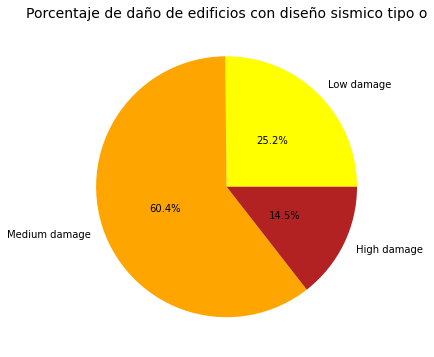

In [725]:
pie, ax = plt.subplots(figsize=[10,6])

plt.pie(x=diseño_o['total_edif_danio'], autopct="%.1f%%",\
        labels=['Low damage', 'Medium damage', 'High damage'], colors=["yellow", "orange", "firebrick"], pctdistance=0.5)
plt.title("Porcentaje de daño de edificios con diseño sismico tipo o", fontsize=14);

### Analisis de diseño m

In [726]:
diseño_m = formatosDF.groupby('plan_configuration').get_group('m')
diseño_m['total_edif_danio'] = diseño_m.groupby('damage_grade')['damage_grade'].transform('count')
del diseño_m['plan_configuration']
diseño_m = diseño_m.set_index('damage_grade').drop_duplicates()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


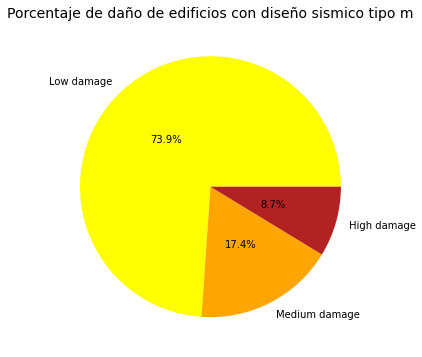

In [727]:
pie, ax = plt.subplots(figsize=[10,6])

plt.pie(x=diseño_m['total_edif_danio'], autopct="%.1f%%",\
        labels=['Low damage', 'Medium damage', 'High damage'], colors=["yellow", "orange", "firebrick"], pctdistance=0.5)
plt.title("Porcentaje de daño de edificios con diseño sismico tipo m", fontsize=14);

### Analisis de diseño n

In [728]:
diseño_n = formatosDF.groupby('plan_configuration').get_group('n')
diseño_n['total_edif_danio'] = diseño_n.groupby('damage_grade')['damage_grade'].transform('count')
del diseño_n['plan_configuration']
diseño_n = diseño_n.set_index('damage_grade').drop_duplicates()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


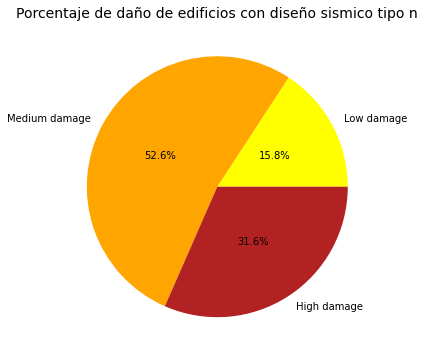

In [729]:
pie, ax = plt.subplots(figsize=[10,6])

plt.pie(x=diseño_n['total_edif_danio'], autopct="%.1f%%",\
        labels=['Low damage', 'Medium damage', 'High damage'], colors=["yellow", "orange", "firebrick"], pctdistance=0.5)
plt.title("Porcentaje de daño de edificios con diseño sismico tipo n", fontsize=14);

### Analisis de diseño f

In [730]:
diseño_f = formatosDF.groupby('plan_configuration').get_group('f')
diseño_f['total_edif_danio'] = diseño_f.groupby('damage_grade')['damage_grade'].transform('count')
del diseño_f['plan_configuration']
diseño_f = diseño_f.set_index('damage_grade').drop_duplicates()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


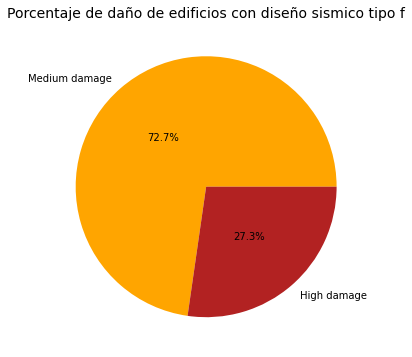

In [731]:
pie, ax = plt.subplots(figsize=[10,6])

plt.pie(x=diseño_f['total_edif_danio'], autopct="%.1f%%",\
        labels=['Medium damage', 'High damage'], colors=["orange", "firebrick"], pctdistance=0.5)
plt.title("Porcentaje de daño de edificios con diseño sismico tipo f", fontsize=14);

### Analisis por promedio

In [732]:
formatosDF['promedio_danio'] = formatosDF.groupby('plan_configuration')['damage_grade'].transform('mean')
formatosDF['cantidad_edificios'] = formatosDF.groupby('plan_configuration')['damage_grade'].transform('count')
del formatosDF['damage_grade']
formatosDF = formatosDF.drop_duplicates()
formatosDF = formatosDF.sort_values(('plan_configuration'), ascending = True).set_index('plan_configuration')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f07ba719150>],
      dtype=object)

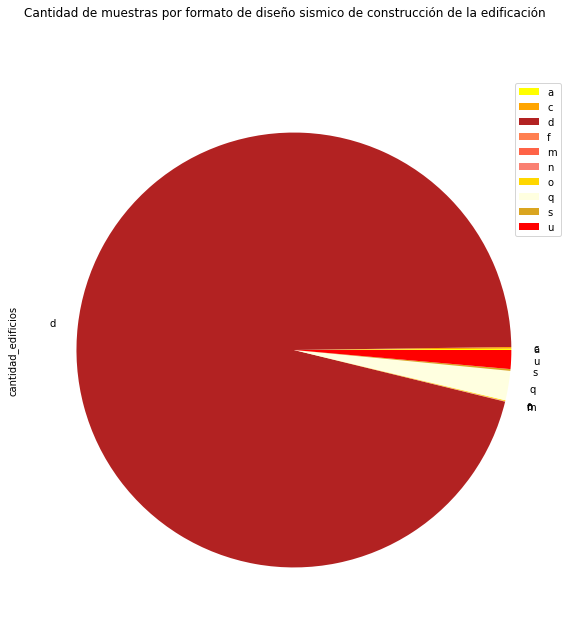

In [733]:
formatosDF.loc[:,['cantidad_edificios']].plot.pie(x='plan_configuration', figsize=(10, 10), subplots=True, title= "Cantidad de muestras por formato de diseño sismico de construcción de la edificación", colors = ['yellow', 'orange', 'firebrick', 'coral', 'tomato', 'salmon', 'gold', 'lightyellow', 'goldenrod', 'red', 'darkorange'])

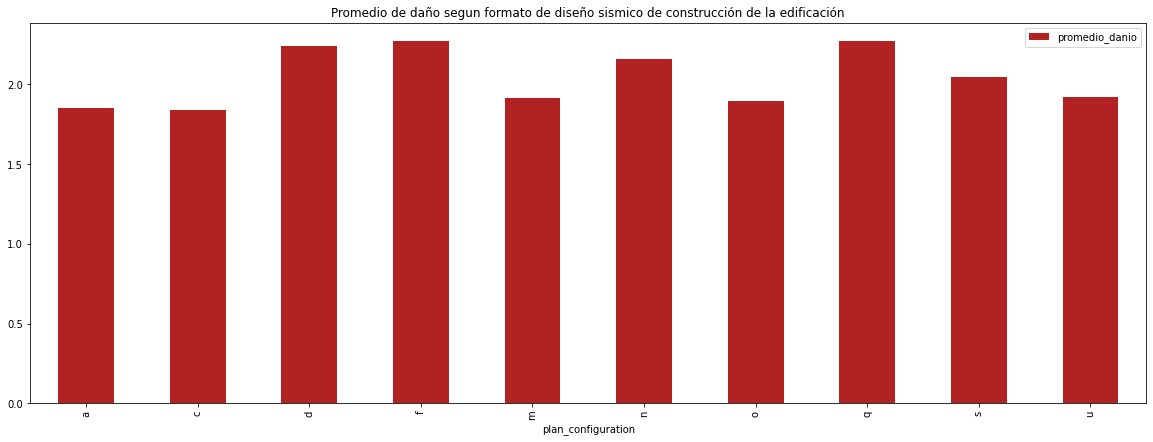

In [734]:
formatosDF.loc[:, ['promedio_danio']].plot(kind= 'bar', figsize= (20, 7), title= "Promedio de daño segun formato de diseño sismico de construcción de la edificación", color= 'firebrick')

En terminos de procentajes, el tipo de diseño q es que mayor daño presento en las edificaciones. Conincide que en promedio es alto el daño, pero en esta comparacion no es de diferencia significativa al resto.

El formato "d" fue el más implementado para el diseño sismico de edificaciones, y es de los de menor porcentage de daño, pero en promedio fue alto.